In [1]:
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE
import numpy as np
import torch

from vade.train import TrainerVaDE
from preprocess import get_ALeRCE_data

In [2]:
class Args:
    num_epochs=1000
    patience=100
    lr=5e-5
    lr_milestones=[150, 300, 450, 600]
    batch_size=128
    pretrain=True
    latent_dim=32
    
args = Args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader_train, scaler, classes = get_ALeRCE_data(args.batch_size, 'train', mode='train')
dataloader_val, _, _ = get_ALeRCE_data(args.batch_size, 'val', mode='val', scaler=scaler)
dataloader_test, _, _ = get_ALeRCE_data(args.batch_size, 'test', mode='test', scaler=scaler)

print(classes)
n_classes = len(classes)
vade = TrainerVaDE(args, dataloader_train, dataloader_val, device, n_classes, scaler)
vade.train()

['Ceph' 'DSCT' 'EB' 'RRL']
Training VaDE...
 1024/27058: [=>..............................] - ETA 5.8s

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 0, Loss: 17888.902, Acc: 24.926
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 0, Loss: 16241.158, Acc: 0.822
Weights saved.
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 1, Loss: 13979.526, Acc: 24.739
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 1, Loss: 12880.723, Acc: 0.822
Weights saved.
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 2, Loss: 11120.220, Acc: 24.907
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 2, Loss: 10267.631, Acc: 0.822
Weights saved.
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 3, Loss: 8884.351, Acc: 25.036
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 3, Loss: 8171.418, Acc: 0.822
Weights saved.
27058/27058: [=======================

4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 34, Loss: 74.462, Acc: 13.335
Weights saved.
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 35, Loss: 65.544, Acc: 30.229
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 35, Loss: 65.340, Acc: 16.789
Weights saved.
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 36, Loss: 57.341, Acc: 31.236
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 36, Loss: 56.317, Acc: 17.188
Weights saved.
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 37, Loss: 50.147, Acc: 32.649
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 37, Loss: 50.428, Acc: 20.358
Weights saved.
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 38, Loss: 43.835, Acc: 34.612
4741/4741: [===============================>]

27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 70, Loss: 7.002, Acc: 64.852
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 70, Loss: 7.098, Acc: 67.780
Weights saved.
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 71, Loss: 6.975, Acc: 65.876
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 71, Loss: 7.067, Acc: 69.786
Weights saved.
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 72, Loss: 6.985, Acc: 65.354
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 72, Loss: 7.055, Acc: 68.643
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 73, Loss: 6.973, Acc: 65.478
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 73, Loss: 7.047, Acc: 69.087
Weights saved.
27058/27058: [===============================>] - ETA 0.0s
Training

4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 106, Loss: 6.907, Acc: 71.686
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 107, Loss: 6.813, Acc: 70.409
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 107, Loss: 6.918, Acc: 72.812
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 108, Loss: 6.790, Acc: 70.556
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 108, Loss: 6.881, Acc: 72.850
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 109, Loss: 6.797, Acc: 70.480
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 109, Loss: 6.863, Acc: 73.684
Weights saved.
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 110, Loss: 6.785, Acc: 70.805
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 110, Loss: 

4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 142, Loss: 6.888, Acc: 73.721
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 143, Loss: 6.735, Acc: 72.387
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 143, Loss: 6.852, Acc: 74.535
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 144, Loss: 6.735, Acc: 72.278
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 144, Loss: 6.885, Acc: 73.993
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 145, Loss: 6.769, Acc: 72.585
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 145, Loss: 6.897, Acc: 74.371
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 146, Loss: 6.746, Acc: 73.013
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 146, Loss: 6.949, Acc: 73.

27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 179, Loss: 6.731, Acc: 73.647
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 179, Loss: 6.875, Acc: 74.350
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 180, Loss: 6.730, Acc: 73.276
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 180, Loss: 6.869, Acc: 74.079
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 181, Loss: 6.738, Acc: 73.799
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 181, Loss: 6.865, Acc: 74.708
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 182, Loss: 6.719, Acc: 73.702
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 182, Loss: 6.905, Acc: 74.350
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 183, Loss: 6.729, Acc:

4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 215, Loss: 6.834, Acc: 76.357
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 216, Loss: 6.695, Acc: 74.588
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 216, Loss: 6.872, Acc: 75.851
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 217, Loss: 6.711, Acc: 74.510
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 217, Loss: 6.851, Acc: 75.366
Weights saved.
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 218, Loss: 6.701, Acc: 75.040
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 218, Loss: 6.870, Acc: 75.206
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 219, Loss: 6.732, Acc: 74.526
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 219, Loss: 6

27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 252, Loss: 6.697, Acc: 75.083
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 252, Loss: 6.856, Acc: 76.583
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 253, Loss: 6.706, Acc: 75.143
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 253, Loss: 6.834, Acc: 75.666
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 254, Loss: 6.726, Acc: 74.920
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 254, Loss: 6.869, Acc: 74.873
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 255, Loss: 6.713, Acc: 75.027
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 255, Loss: 6.868, Acc: 74.811
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 256, Loss: 6.710, Acc: 

4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 288, Loss: 6.842, Acc: 76.357
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 289, Loss: 6.715, Acc: 74.915
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 289, Loss: 6.869, Acc: 76.172
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 290, Loss: 6.702, Acc: 75.315
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 290, Loss: 6.851, Acc: 75.284
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 291, Loss: 6.706, Acc: 75.324
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 291, Loss: 6.872, Acc: 75.029
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 292, Loss: 6.707, Acc: 74.906
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 292, Loss: 6.839, Acc: 74.4

27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 325, Loss: 6.693, Acc: 75.367
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 325, Loss: 6.862, Acc: 75.658
27058/27058: [===============================>] - ETA 0.1ss
Training VaDE... Epoch: 326, Loss: 6.709, Acc: 75.559
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 326, Loss: 6.844, Acc: 77.138
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 327, Loss: 6.706, Acc: 75.693
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 327, Loss: 6.904, Acc: 73.935
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 328, Loss: 6.704, Acc: 75.477
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 328, Loss: 6.881, Acc: 75.345
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 329, Loss: 6.699, Acc: 

4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 361, Loss: 6.820, Acc: 77.076
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 362, Loss: 6.700, Acc: 75.630
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 362, Loss: 6.867, Acc: 75.502
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 363, Loss: 6.689, Acc: 75.530
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 363, Loss: 6.826, Acc: 77.023
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 364, Loss: 6.695, Acc: 75.411
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 364, Loss: 6.877, Acc: 76.365
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 365, Loss: 6.696, Acc: 76.030
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 365, Loss: 6.836, Acc: 76.22

27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 398, Loss: 6.711, Acc: 75.359
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 398, Loss: 6.857, Acc: 77.105
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 399, Loss: 6.690, Acc: 75.439
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 399, Loss: 6.879, Acc: 76.846
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 400, Loss: 6.700, Acc: 76.033
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 400, Loss: 6.889, Acc: 75.613
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 401, Loss: 6.706, Acc: 75.631
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 401, Loss: 6.917, Acc: 74.420
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 402, Loss: 6.699, Acc: 75

4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 434, Loss: 6.860, Acc: 76.324
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 435, Loss: 6.694, Acc: 76.053
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 435, Loss: 6.807, Acc: 76.776
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 436, Loss: 6.720, Acc: 75.337
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 436, Loss: 6.823, Acc: 77.508
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 437, Loss: 6.673, Acc: 76.114
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 437, Loss: 6.881, Acc: 75.366
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 438, Loss: 6.688, Acc: 75.749
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 438, Loss: 6.865, Acc: 77.31

27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 471, Loss: 6.701, Acc: 75.887
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 471, Loss: 6.860, Acc: 75.530
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 472, Loss: 6.702, Acc: 75.901
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 472, Loss: 6.853, Acc: 76.250
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 473, Loss: 6.689, Acc: 75.879
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 473, Loss: 6.850, Acc: 77.241
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 474, Loss: 6.689, Acc: 75.677
4741/4741: [===============================>] - ETA 0.0s
Testing VaDE... Epoch: 474, Loss: 6.813, Acc: 75.983
27058/27058: [===============================>] - ETA 0.0s
Training VaDE... Epoch: 475, Loss: 6.693, Acc: 75

In [3]:
vade.load_weights()

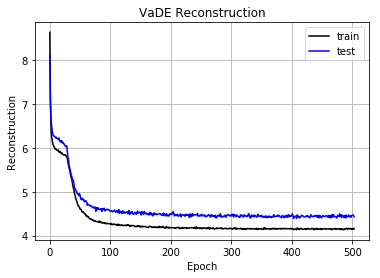

In [4]:
def plot_loss(values, values_t, metric):
    plt.plot(np.arange(len(values)), values, c='k', label='train')
    plt.plot(np.arange(len(values_t)), values_t, c='b', label='test')
    plt.title('VaDE {}'.format(metric))
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid(True)

plot_loss(np.array(vade.rec), np.array(vade.rec_t), 'Reconstruction')

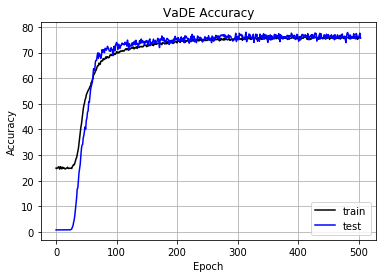

In [5]:
plot_loss(np.array(vade.acc), np.array(vade.acc_t), 'Accuracy')

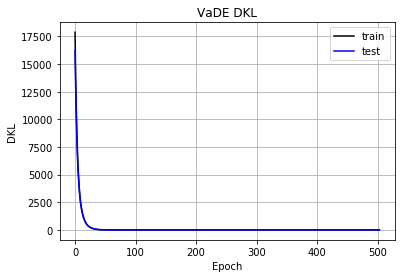

In [6]:
plot_loss(np.array(vade.dkl), np.array(vade.dkl_t), 'DKL')

In [7]:
latents = []
labels2 = []
vade.VaDE.eval()
print('Testing...')
with torch.no_grad():
    for x, _, y2 in dataloader_train:
        x = x.float().to(device)
        x_hat, _, _, z = vade.VaDE(x)
        latents.append(z.detach().cpu())
        labels2.append(y2.cpu())
labels2 = torch.cat(labels2).numpy()
latents = torch.cat(latents).numpy()

Testing...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [8]:
x_embedded = TSNE(n_components=2).fit_transform(latents)

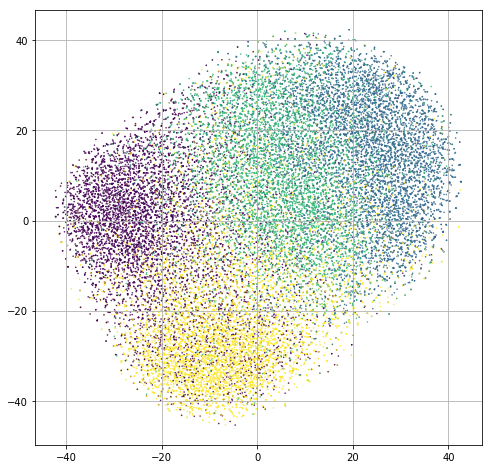

In [9]:
plt.figure(figsize=(8,8))
cmap = plt.get_cmap('jet', 4)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], c=labels2, 
            s=1, alpha=1, marker='.')
plt.grid(True)

In [10]:
x

tensor([[0.7122, 0.4495, 0.4331,  ..., 0.0000, 0.4854, 0.2470],
        [0.7503, 0.1615, 0.2428,  ..., 0.0000, 0.3798, 0.3373],
        [0.5999, 0.7002, 0.3885,  ..., 0.0000, 0.2930, 0.3714],
        ...,
        [0.0746, 0.1289, 0.2388,  ..., 0.0000, 0.4359, 0.5296],
        [0.1240, 0.0000, 0.6112,  ..., 0.3382, 0.5343, 0.6061],
        [0.7514, 0.8311, 0.8791,  ..., 0.6003, 0.3903, 0.0166]],
       device='cuda:0')

In [11]:
x_hat

tensor([[0.6773, 0.3794, 0.3663,  ..., 0.2322, 0.4363, 0.4355],
        [0.7128, 0.3857, 0.3763,  ..., 0.1598, 0.4132, 0.4353],
        [0.6693, 0.2748, 0.3031,  ..., 0.1752, 0.3899, 0.4032],
        ...,
        [0.1135, 0.3843, 0.4861,  ..., 0.3389, 0.4927, 0.5314],
        [0.1396, 0.3565, 0.4400,  ..., 0.5461, 0.4822, 0.5414],
        [0.7040, 0.4527, 0.4020,  ..., 0.2139, 0.4062, 0.3980]],
       device='cuda:0')

In [12]:
import torch
import torch.nn.functional as F

from sklearn.metrics import roc_auc_score

def eval(net, dataloader, device):
    """Testing the VaDE model"""

    scores = []
    latents = []
    labels1 = []
    labels2 = []
    net.eval()
    print('Testing...')
    with torch.no_grad():
        for x, y1, y2 in dataloader:
            x = x.float().to(device)
            x_hat, _, _, z = net(x)
            score = F.mse_loss(x_hat, x, reduction='none')
            score = torch.sum(score, dim=1)

            scores.append(score.detach().cpu())
            latents.append(z.detach().cpu())
            labels1.append(y1.cpu())
            labels2.append(y2.cpu())
            
    labels1, labels2 = torch.cat(labels1).numpy(), torch.cat(labels2).numpy(), 
    scores, latents = torch.cat(scores).numpy(), torch.cat(latents).numpy()
    print('ROC AUC score: {:.3f}'.format(roc_auc_score(labels1, scores)))
    return labels1, labels2, scores, latents

In [13]:
labels1, labels2, scores, latent = eval(vade.VaDE, dataloader_test, device)

Testing...
ROC AUC score: 0.502


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [14]:
x_embedded = TSNE(n_components=2).fit_transform(latent)

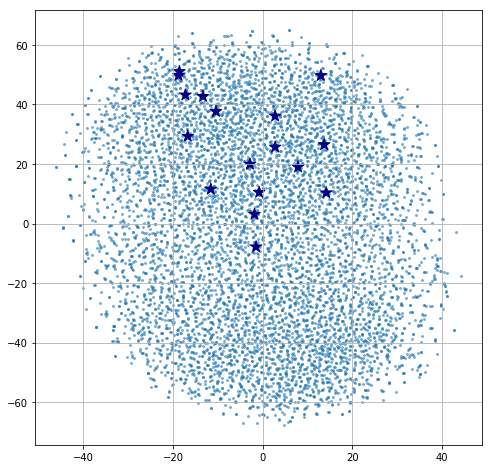

In [15]:
plt.figure(figsize=(8,8))
cmap = plt.get_cmap('jet', 4)
plt.scatter(x_embedded[:, 0][labels2==0], x_embedded[:, 1][labels2==0],
            s=15, alpha=0.5, marker='.')
plt.scatter(x_embedded[:, 0][labels2!=0], x_embedded[:, 1][labels2!=0], 
            c=labels2[labels2!=0].reshape(-1,),
            s=150, cmap=cmap, marker='*')

plt.grid(True)

In [16]:
scores_in = scores[labels1==0]
scores_out = scores[labels1==1]

scores_ELL = scores[labels2==1]
scores_TDE = scores[labels2==2]
scores_SNIIb = scores[labels2==3]
scores_WRayot = scores[labels2==4]

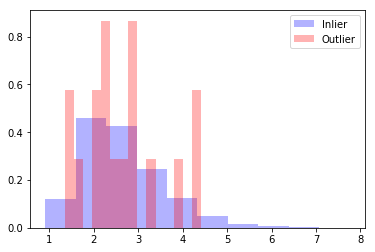

In [17]:
plt.hist(scores_in, bins=10, color='b', alpha=0.3, density=True, label='Inlier')
plt.hist(scores_out, bins=15, color='r', alpha=0.3, density=True, label='Outlier')
plt.legend()

In [18]:
import torch
from torch.utils.data import DataLoader

from sklearn.preprocessing import QuantileTransformer
import numpy as np
import pandas as pd


class ALeRCELoader(object):
    def __init__(self, dataset, normal_class, mode="train", scaler=None):
        
        data = pd.read_pickle('{}_data.pkl'.format(dataset))
        data = data[(data['n_det_1']>=10) & (data['n_det_2']>=10)]
        importances = np.load('importances.npy').item()
        x = data[importances['periodic_importance']]
        y = data[['classALeRCE', 'hierClass', 'outClass']]
        
        if scaler is None:
            scaler = QuantileTransformer(n_quantiles=5)
            scaler.fit(x)
        self.scaler = scaler
        x = scaler.transform(x)
        x[np.isnan(x)] = 0
        
        anormal_classes = ['Periodic', 'Transient', 'Stochastic']
        anormal_classes.remove(normal_class)
        
        if mode =='train' or mode=='val':
            self.x = x[y.hierClass==normal_class]
            
            y1 = y.hierClass[y.hierClass==normal_class]
            y1 = np.where(y1==normal_class, 0, 1)
            self.y1 = y1.reshape(y1.shape[0],).astype('int8')
            
            y2 = y.classALeRCE[y.hierClass==normal_class]
            print(np.unique(y2))
            for i, class_ in enumerate(np.unique(y2)):
                y2 = np.where(y2==class_, i, y2)
            self.y2 = y2.reshape(y2.shape[0],).astype('int8')
            
        elif mode=='test':
            self.x = x
            
            y1 = y.hierClass
            y1 = np.where(y1==normal_class, 0, 1)
            self.y1 = y1.reshape(y1.shape[0],).astype('int8')

            y2 = y.hierClass
            y2 = np.where(y2==normal_class, 0, y2)
            for i, anormal_class in enumerate(anormal_classes):
                print(anormal_class)
                y2 = np.where(y2==anormal_class, i+1, y2)
            self.y2 = y2.reshape(y2.shape[0],).astype('int8')
            

    def __len__(self):
        """
        Number of images in the object dataset.
        """
        return self.x.shape[0]

    def __getitem__(self, index):
        return np.float32(self.x[index]), np.float32(self.y1[index]), np.float32(self.y2[index])
        

def get_ALeRCE_data(batch_size, dataset, normal_class, mode='train', scaler=None):
    """Build and return data loader."""
    shuffle=True
    
    data = ALeRCELoader(dataset, normal_class, mode=mode, scaler=scaler)
    if mode == 'train':
        class_sample_count = np.unique(data.y2[:,0], return_counts=True)[1]
        weights = 1. / torch.Tensor(class_sample_count)
        samples_weight = np.array([weights[t] for t in data.y2[:,0]])
        samples_weight = torch.from_numpy(samples_weight)
        sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), 
                                                                 len(samples_weight))
        data_loader = DataLoader(dataset=data,
                                 batch_size=batch_size, sampler=sampler)
    else:
        data_loader = DataLoader(dataset=data,
                                 batch_size=batch_size,
                                 shuffle=False)
    return data_loader, data.scaler

In [19]:
dataloader_test, _ = get_ALeRCE_data(args.batch_size, 'test', 'Periodic', mode='test', scaler=scaler)


Transient
Stochastic


In [20]:
labels1, labels2, scores, latent = eval(vade.VaDE, dataloader_test, device)

Testing...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


ROC AUC score: 0.881


In [21]:
x_embedded = TSNE(n_components=2).fit_transform(latent)

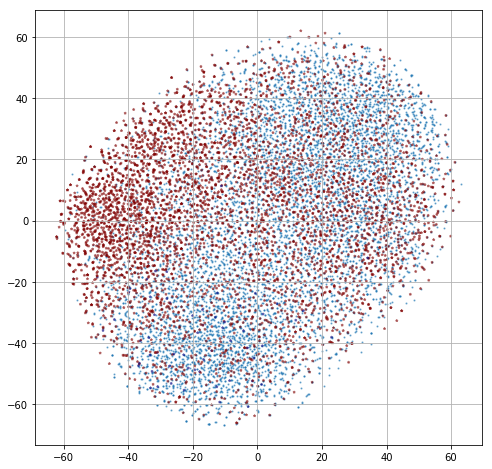

In [22]:
labels2 = labels2.reshape(-1,)
plt.figure(figsize=(8,8))
cmap = plt.get_cmap('jet', 4)
plt.scatter(x_embedded[:, 0][labels2==0], x_embedded[:, 1][labels2==0],
            s=5, alpha=0.5, marker='.')
plt.scatter(x_embedded[:, 0][labels2!=0], x_embedded[:, 1][labels2!=0], 
            c=labels2[labels2!=0].reshape(-1,), alpha=0.5,
            s=5, cmap=cmap, marker='*')

plt.grid(True)

In [23]:
scores_in = scores[labels1==0]
scores_out = scores[labels1==1]

scores_ELL = scores[labels2==1]
scores_TDE = scores[labels2==2]
scores_SNIIb = scores[labels2==3]
scores_WRayot = scores[labels2==4]

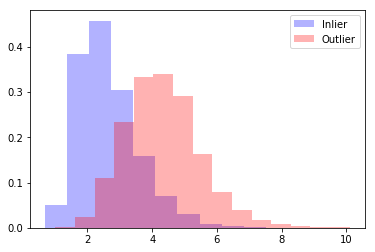

In [24]:
plt.hist(scores_in, bins=10, color='b', alpha=0.3, density=True, label='Inlier')
plt.hist(scores_out, bins=15, color='r', alpha=0.3, density=True, label='Outlier')
plt.legend()